### So here I will to compare the vcfs (obtained by pooling both lanes of sequencing) with and without the min-maf = 0.05 filter to see if we can find the reason for such large number of low frequency snps. 


In [36]:
from __future__ import division

In [58]:
% matplotlib inline
import vcf
import MISC_RAD_tools as MISC
import numpy as np
from matplotlib import pyplot as plt

So here's the problem, when looking at the SNP loci obtained from Stacks, we have a huge number of very low frequency SNPs:

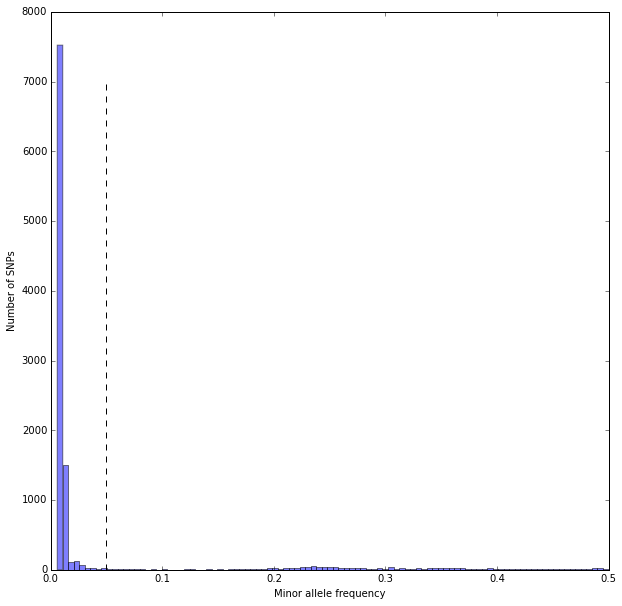

In [21]:
unfiltered_vcf = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2_unfiltered.vcf", 'r'))

snp_freqs = []

count = 0
for record in unfiltered_vcf:
    snp_freqs.append(record.aaf[0])
    count +=1 

plt.figure(figsize=(10,10))
plt.hist(snp_freqs, bins=100, alpha = 0.5)
plt.xlabel("Minor allele frequency")
plt.ylabel("Number of SNPs")
plt.vlines(0.05, 0, 7000, linestyle = "dashed")
plt.show()

** dashed line above is the 0.05 cut-off for the maf used in Stacks. 

Such a pattern can be indicative of contamination, whereby many different types of bacteria also get sequenced. As bacteria are so genetically diverse, this can result in SNPs present in only one or two samples (i.e. low frequency). If this was the case, then we would expect these loci to be low coverage, as the amount of bacterial DNA going into the librarie should be much much lower than the amount of the target DNA. 

So now I will look at the coverage in the loci that have low maf and compare it to those loci that are kept after filtering.

In [22]:
## Getting lists of filtered and kept loci

unfiltered_vcf = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2_unfiltered.vcf", 'r'))
min_maf_filtered_vcf = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2_min_maf_filtered.vcf", 'r'))

record_counter = 0
unfiltered_snp_ids = []

for record in unfiltered_vcf:
    record_counter += 1
    unfiltered_snp_ids.append("%s_%s" % (record.ID, record.POS))
    
print "Number of SNP loci before filtering = %s" % record_counter


record_counter = 0
min_maf_filtered_snp_ids = []

for record in min_maf_filtered_vcf:
    record_counter += 1
    min_maf_filtered_snp_ids.append("%s_%s" % (record.ID, record.POS))
    
print "Number of SNP loci after min_maf filtering = %s" % record_counter

low_maf_snps = []

for loc in unfiltered_snp_ids:
    if loc not in min_maf_filtered_snp_ids:
        low_maf_snps.append(loc)
        
print "Number of SNP loci thrown out by min_maf filtering = %s" % len(low_maf_snps)

## Checkt that the lists are correct.

if len(low_maf_snps) == (len(unfiltered_snp_ids)-len(min_maf_filtered_snp_ids)):
    print "Lists numbers check out"
else:
    print "List numbers don't add up"

Number of SNP loci before filtering = 10866
Number of SNP loci after min_maf filtering = 1449
Number of SNP loci thrown out by min_maf filtering = 9417
Lists numbers check out


In [16]:
## Now get the average coverages across samples for each locus, keeping low maf and kept loci separate. 

unfiltered_vcf = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2_unfiltered.vcf", 'r'))

low_maf_coverages = []
kept_loci_coverages = []

for record in unfiltered_vcf:
    sample_covs = []
    if "%s_%s" % (record.ID, record.POS) in low_maf_snps:
        for sample in record.samples:
            sample_covs.append(sample['DP'])
        low_maf_coverages.append(np.mean(sample_covs))
    
    else:
        for sample in record.samples:
            sample_covs.append(sample['DP'])
        kept_loci_coverages.append(np.mean(sample_covs))
        
print len(low_maf_coverages)
print len(kept_loci_coverages)
        

9417
1449


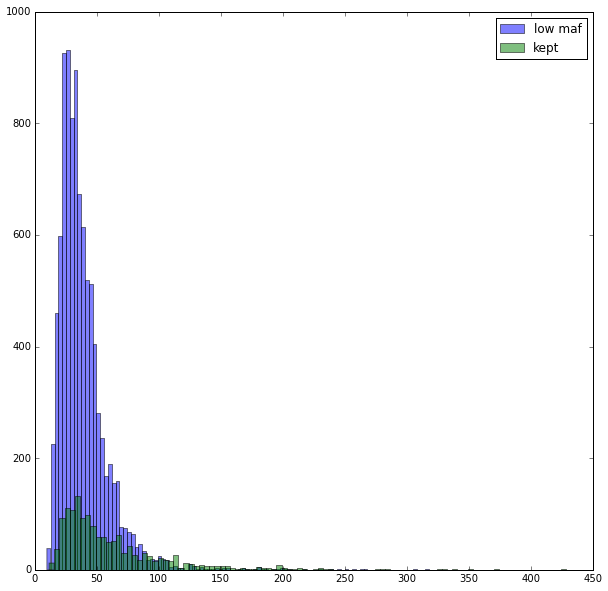

In [22]:
## Now plotting the coverage on histogram

bins = 100
plt.figure(figsize=(10,10))
plt.hist(low_maf_coverages, bins, alpha=0.5, label='low maf')
plt.hist(kept_loci_coverages, bins, alpha=0.5, label='kept')
plt.legend(loc='upper right')
plt.show()

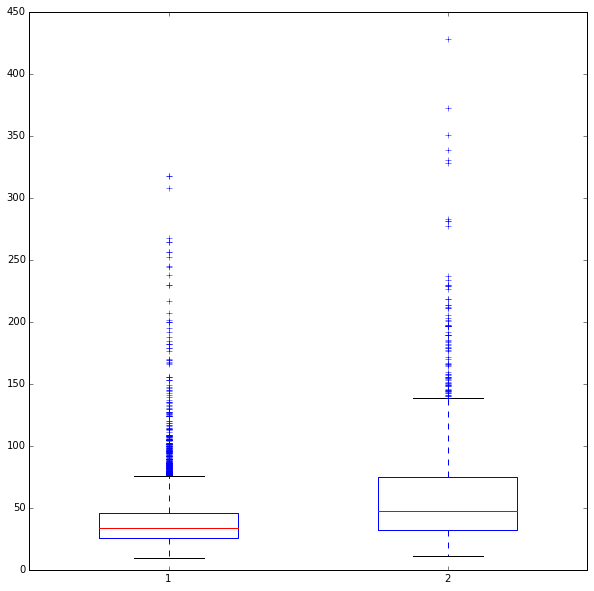

In [30]:
## And also in a box plot

plt.figure(figsize=(10,10))
plt.boxplot([low_maf_coverages, kept_loci_coverages], widths=0.5)
plt.show()

So the coverage patterns are really not that different between the < 0.05 maf and > 0.05 maf loci.

This suggests that infact, contamination isn't responsible for this frequency pattern.

So I think that perhaps this is true biological signal, which results from the asexual reproduction in parthenogens. 

Here's my thinking:

Normally, when a SNP arises it either drifts to extinction, or it drifts to higher frequency through the population via recombination. Obviously in parthenogens recombination is not an option. So, a SNP that arises in a parthenogen can only reach high frequency if the direct descendents of that parthenogen make up a large proportion of the population. This is going to be unlikely in most cases.

So I think what we are seeing is simply parthenogen-lineage-specific mutations, that are unable to reach higher frequencies. 

A way to test this would be to generate a vcf just for the sexuals, and see if the same pattern exists. 



### Sexuals only

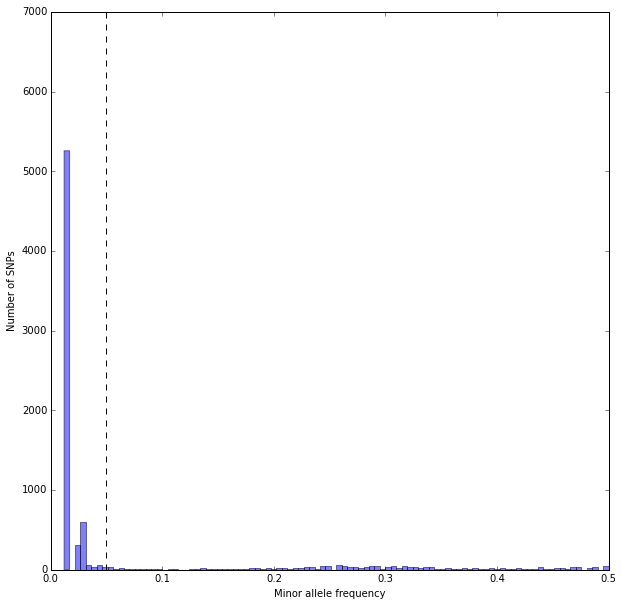

In [23]:
sexuals_only_vcf = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2_sexuals_only_unfiltered.vcf", 'r'))

sexual_feqs = [] ## not to be confused with sexual freaks! Different things completely!

for record in sexuals_only_vcf:
    sexual_feqs.append(record.aaf[0])

plt.figure(figsize=(10,10))
plt.hist(sexual_feqs, bins=100, alpha = 0.5)
plt.xlabel("Minor allele frequency")
plt.ylabel("Number of SNPs")
plt.vlines(0.05, 0, 7000, linestyle = "dashed")
plt.show()


### Parths only

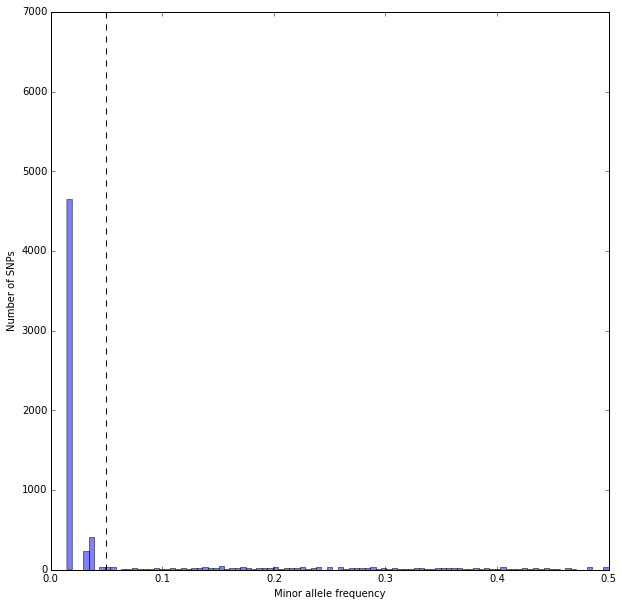

In [24]:
sexuals_only_vcf = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2_parths_only_unfiltered.vcf", 'r'))

sexual_feqs = [] 

for record in sexuals_only_vcf:
    sexual_feqs.append(record.aaf[0])

plt.figure(figsize=(10,10))
plt.hist(sexual_feqs, bins=100, alpha = 0.5)
plt.xlabel("Minor allele frequency")
plt.ylabel("Number of SNPs")
plt.vlines(0.05, 0, 7000, linestyle = "dashed")
plt.show()

### Looking at the allele frequencies in sexuals and parthenogens in the min_maf filtered data

In [44]:
min_maf_filtered_vcf = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2_min_maf_filtered.vcf", 'r'))
first_rec = min_maf_filtered_vcf.next()

parths = []
sexuals = []

for sample in first_rec.samples:
    if "P" in sample.sample:
        parths.append(sample.sample)
    elif "S" in sample.sample:
        sexuals.append(sample.sample)

        
min_maf_filtered_vcf = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2_min_maf_filtered.vcf", 'r'))

## Get allele freqs

freqs = {}
freqs["sexuals"] = {}
freqs["parths"] = {}

for record in min_maf_filtered_vcf:
    loc_id = "%s_%s" % (record.ID, record.POS)
    

    
    sexual_ref_counts = 0
    parth_ref_counts = 0
    sexuals_called = 0
    parths_called = 0
    
    
    for sample in record:
        if sample.called:
            if sample.sample in sexuals:
                
                sexuals_called += 1
                                
                if "1/1" in sample['GT']:
                    sexual_ref_counts += 2
                elif "1" in sample['GT']:
                    sexual_ref_counts += 1
            
            if sample.sample in parths:
                
                parths_called += 1
                                
                if "1/1" in sample['GT']:
                    parth_ref_counts += 2
                elif "1" in sample['GT']:
                    parth_ref_counts += 1
    
    freqs["sexuals"][loc_id] = sexual_ref_counts/(sexuals_called*2)
    freqs["parths"][loc_id] = parth_ref_counts/(parths_called*2)
    
    



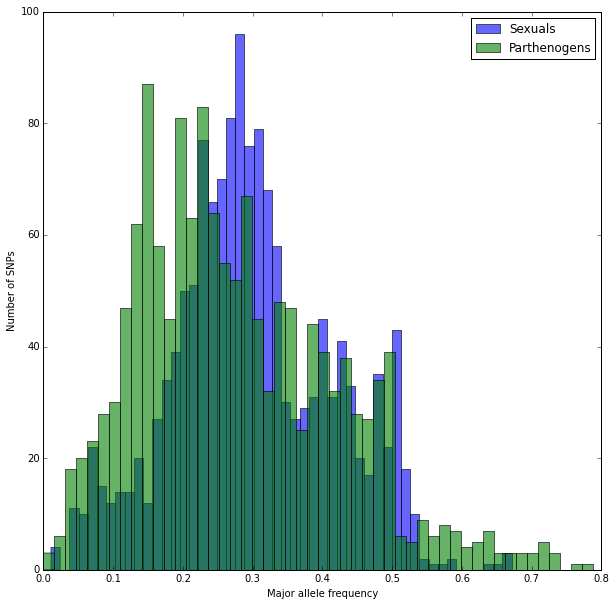

In [51]:
## Plot the data
plt.figure(figsize=(10,10))
plt.hist(freqs["sexuals"].values(), bins=50, alpha = 0.6, label = "Sexuals")
plt.hist(freqs["parths"].values(), bins=50, alpha = 0.6, label = "Parthenogens")
plt.xlabel("Major allele frequency")
plt.ylabel("Number of SNPs")
plt.legend(loc='upper right')
plt.show()


### Subsample the number of sexuals, to check that this isn't just an effect of imbalenced sample sizes. . . 

34 parthenogens  
49 sexuals

In [95]:
import random
sub_sexuals = random.sample(sexuals, 34)

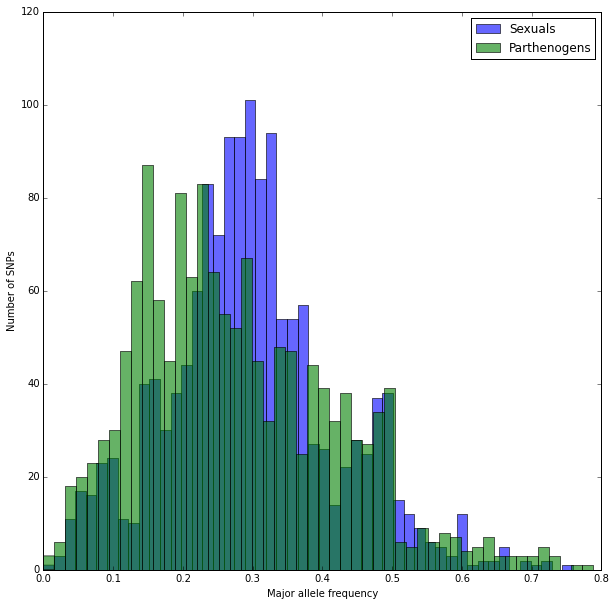

In [97]:
min_maf_filtered_vcf = vcf.Reader(open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2_min_maf_filtered.vcf", 'r'))

## Get allele freqs

freqs = {}
freqs["sexuals"] = {}
freqs["parths"] = {}

for record in min_maf_filtered_vcf:
    loc_id = "%s_%s" % (record.ID, record.POS)
    

    
    sexual_ref_counts = 0
    parth_ref_counts = 0
    sexuals_called = 0
    parths_called = 0
    
    
    for sample in record:
        if sample.called:
            if sample.sample in sub_sexuals:
                
                sexuals_called += 1
                                
                if "1/1" in sample['GT']:
                    sexual_ref_counts += 2
                elif "1" in sample['GT']:
                    sexual_ref_counts += 1
            
            if sample.sample in parths:
                
                parths_called += 1
                                
                if "1/1" in sample['GT']:
                    parth_ref_counts += 2
                elif "1" in sample['GT']:
                    parth_ref_counts += 1
    
    freqs["sexuals"][loc_id] = sexual_ref_counts/(sexuals_called*2)
    freqs["parths"][loc_id] = parth_ref_counts/(parths_called*2)
    
## Plot the data
plt.figure(figsize=(10,10))
plt.hist(freqs["sexuals"].values(), bins=50, alpha = 0.6, label = "Sexuals")
plt.hist(freqs["parths"].values(), bins=50, alpha = 0.6, label = "Parthenogens")
plt.xlabel("Major allele frequency")
plt.ylabel("Number of SNPs")
plt.legend(loc='upper right')
plt.show()

### Now I will take a look at the loci that are filtered by the min-maf again, to make sure that it is not just well reproduced bacterial contamination. 

To do this I will blast these seqs against genbank and see what they hit. 

In [65]:
import gzip

In [68]:
## First get the sequecnces for the filtered loci. . . 

def fasta_maka(whitey, cat):

    """
    whitey = whitelist containing locus IDs in the form of "<Tag_ID>_<Position>"
    cat    = path to the catalog file to get sequences from

    """


    loci = whitey

    if cat.endswith("gz"):
        tags = gzip.open(cat, 'r').readlines()
    else:
        tags = open(cat, 'r').readlines()

    ## Pull out the locus ID's from the whitelist

    Loc_IDs = []
    for locus in loci:
        if locus.startswith("compli"):
            Loc_id = locus.split("_")[1]
        else:
            Loc_id = locus.split("_")[0]
        Loc_IDs.append(Loc_id)
    print Loc_IDs
    print "Number of tags in whitelist:",len(Loc_IDs)

    ## Write the fasta

    fasta = open("%s/%s" % (cat.rpartition('/')[0], '/Whitelist_tags.fa'), 'w')

    count = 0
    for line in tags:
        if 'consensus' in line:
            Tag_ID = line.split()[2]
            if Tag_ID in Loc_IDs:
                count+=1
                fasta.write('>'+ Tag_ID +'\n'+line.split()[8]+'\n')
                #print '>'+ Tag_ID +'\n'+line.split()[8]+'\n'
    print count, "sequences"

    fasta.close()

In [69]:
fasta_maka(low_maf_snps, "/home/djeffrie/Data/Caspers_data/Min_maf_comparison/batch_2.catalog.tags.tsv.gz")

['3', '3', '3', '3', '4', '4', '4', '8', '8', '10', '12', '12', '13', '13', '13', '15', '15', '16', '16', '16', '16', '18', '21', '21', '21', '21', '22', '24', '24', '24', '27', '27', '27', '28', '28', '28', '28', '31', '31', '48', '48', '59', '59', '59', '59', '59', '59', '70', '70', '70', '97', '97', '97', '97', '100', '100', '103', '103', '107', '107', '107', '107', '115', '115', '127', '127', '127', '127', '127', '136', '136', '139', '144', '144', '151', '155', '155', '155', '157', '157', '160', '160', '167', '180', '182', '182', '187', '189', '189', '189', '189', '199', '200', '200', '200', '223', '223', '223', '223', '226', '226', '226', '226', '226', '226', '226', '226', '230', '230', '230', '237', '237', '237', '237', '237', '248', '253', '259', '259', '259', '259', '259', '259', '267', '267', '267', '267', '271', '273', '273', '273', '273', '285', '287', '287', '287', '287', '288', '288', '288', '288', '288', '288', '288', '288', '288', '288', '296', '296', '296', '299', '299'

### Now blast these against the genbank nt database

In [99]:
help(NCBIWWW.qblast)

Help on function qblast in module Bio.Blast.NCBIWWW:

qblast(program, database, sequence, auto_format=None, composition_based_statistics=None, db_genetic_code=None, endpoints=None, entrez_query='(none)', expect=10.0, filter=None, gapcosts=None, genetic_code=None, hitlist_size=50, i_thresh=None, layout=None, lcase_mask=None, matrix_name=None, nucl_penalty=None, nucl_reward=None, other_advanced=None, perc_ident=None, phi_pattern=None, query_file=None, query_believe_defline=None, query_from=None, query_to=None, searchsp_eff=None, service=None, threshold=None, ungapped_alignment=None, word_size=None, alignments=500, alignment_view=None, descriptions=500, entrez_links_new_window=None, expect_low=None, expect_high=None, format_entrez_query=None, format_object=None, format_type='XML', ncbi_gi=None, results_file=None, show_overview=None, megablast=None)
    Do a BLAST search using the QBLAST server at NCBI.
    
    Supports all parameters of the qblast API for Put and Get.
    Some useful par

In [103]:
for i in result_handle:
    print i

ValueError: I/O operation on closed file

In [101]:
## Doing this via the internet, not locally (not enough space)

from Bio.Blast import NCBIWWW

fasta_string = open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/Whitelist_tags.fa").read()

result_handle = NCBIWWW.qblast("blastn", "nt", fasta_string)

save_file = open("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/my_blast.xml", "w", megablast = True, hitlist_size = 5)
save_file.write(result_handle.read())
save_file.close()
result_handle.close()

HTTPError: HTTP Error 403: Forbidden

In [82]:
def DansBlastParse(blast_xml_output, best_hit_criteria, Eval_thresh):
    """
    
    Usage: BlastParseExtra.py  <blast_xml_output>  <best_hit_criteria>  <Evalue_threshold>
    
    <blast_xml_output>  -  Path should be absolute
    <best_hit_criteria> -  Orders of magnitude higher that best hit has to be in multi
    <Evalue_threshold>  -  (1e-20 is default)
    
    
    This script first filters the mappings in the <blast_xml_output>, for only those where the
    best hit is at least 5 orders of magnitude higher than the second.
    
    """

    import sys
    import os
    from Bio.Blast import NCBIXML
    from Bio import SeqIO
    
    
    blast = NCBIXML.parse(open(blast_xml_output,"r"))

    good_blast_counts = 0
    uniq_counts = 0
    
    ## From Alan's script: Returns blast hits only when the best e-value is 5 orders of magnitude better than the second best.
    for record in blast :
        #print len(record.alignments)
        if len(record.alignments)==1:  ## Extra else statement - this wasn't in Alan's original script.
            if float(record.alignments[0].hsps[0].expect) < Eval_thresh:
                subject = str(record.alignments[0].hit_def)
                Evalue = float(record.alignments[0].hsps[0].expect)
                Hit_start_coord = int(record.alignments[0].hsps[0].sbjct_start)
                Hit_end_coord = int(record.alignments[0].hsps[0].sbjct_end)
                print "Unique\t%s\t%s\t%s\t%s\t%s" % (record.query, subject, Evalue, Hit_start_coord, Hit_end_coord)
                good_blast_counts += 1
                uniq_counts += 1
        
        elif len(record.alignments)>1:
            if all([record.alignments[0].hsps[0].expect < best_hit_criteria * record.alignments[1].hsps[0].expect, record.alignments[0].hsps[0].expect <= Eval_thresh]):
                
                subject = str(record.alignments[0].hit_def)
                Evalue = float(record.alignments[0].hsps[0].expect)
                Hit_start_coord = int(record.alignments[0].hsps[0].sbjct_start)
                Hit_end_coord = int(record.alignments[0].hsps[0].sbjct_end)
                print "Multi\t%s\t%s\t%s\t%s\t%s" % (record.query, subject, Evalue, Hit_start_coord, Hit_end_coord)
                good_blast_counts += 1


    print "Number of good blast hits:", good_blast_counts
    print "Number of unique mappings:", uniq_counts


In [78]:
from Bio.Blast import NCBIXML

blast_records = NCBIXML.parse(result_handle)

In [104]:
DansBlastParse("/home/djeffrie/Data/Caspers_data/Min_maf_comparison/my_blast.xml", 0, 0)

Number of good blast hits: 0
Number of unique mappings: 0
